In [3]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Feature Engineering

In [4]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


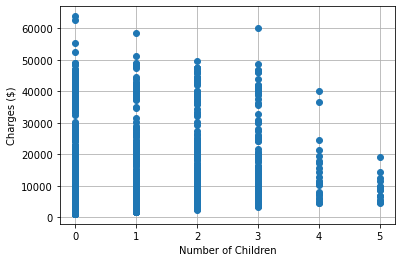

In [6]:
plt.plot('children', 'charges', 'o', data = insurance)
plt.xlabel('Number of Children')
plt.ylabel('Charges ($)')
plt.grid()
plt.show()

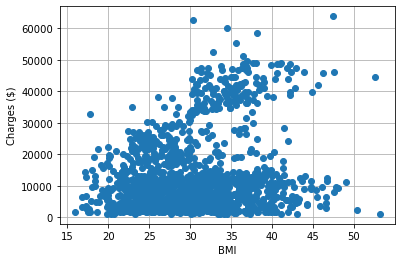

In [7]:
plt.plot('bmi', 'charges', 'o', data = insurance)
plt.xlabel('BMI')
plt.ylabel('Charges ($)')
plt.grid()
plt.show()